# Melanoma Detection Assignment

### Problem Statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import keras_cv
from glob import glob
import tqdm as notebook_tqdm

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('./Train')
data_dir_test = pathlib.Path('./Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [5]:
# Note keras.preprocessing was deprecated in v2.9.1, utils should be used instead.

from tensorflow.keras.utils import load_img

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 12592 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [9]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

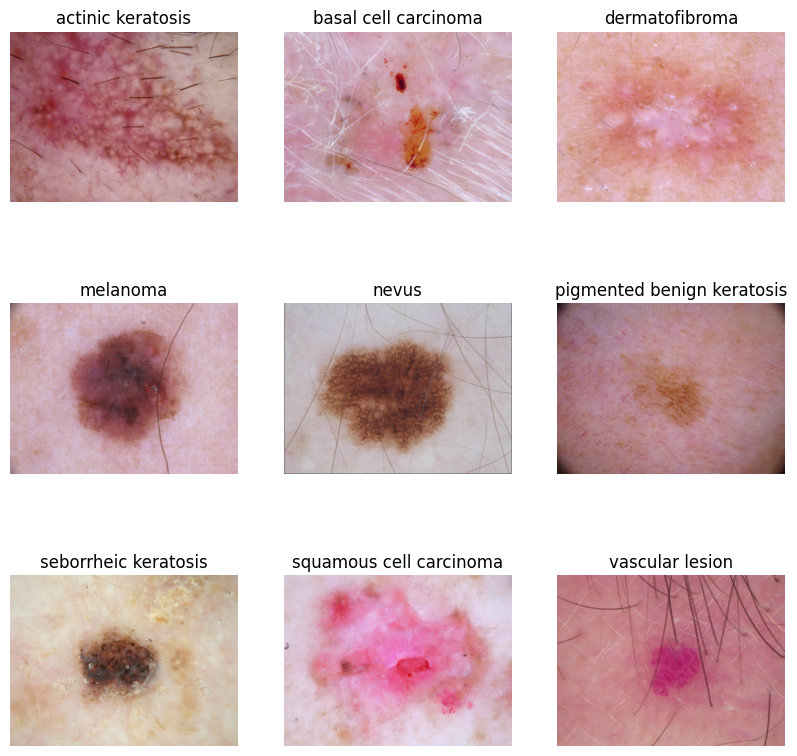

In [10]:
plt.figure(figsize=(10,10))

for lesion_type in range(class_number):
    class_path = glob(os.path.join(data_dir_train, class_names[lesion_type], '*'))
    lesion_imgs = list(class_path)
    img=PIL.Image.open(str(lesion_imgs[0]))
    ax = plt.subplot(3,3, lesion_type+1)
    plt.imshow(img)
    plt.title(class_names[lesion_type])
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
cached_train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
cached_val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Creation

In [12]:
# Note the first layer (Rescaling(1./255) rescales the RGB channel values.

num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

c:\Users\NC101478\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### Model Compilation

#### Justification for optimizer choice.
While stochastic gradient descent ('sgd') is known to generalise better than adaptive moment estimation ('adam'), we have opted to use adam due to time constraints as it has a tendency to converge faster. The project pipeline states that the number of epochs to use be 20, so this makes sense considering the specific circumstances of this project. Ideally, the use of an ensemble approach applying both optimizers may be a better choice, but is outside the constraints of this project.

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,659,081 (6.33 MB)

 Trainable params: 1,659,081 (6.33 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [15]:
epochs = 20
history = model.fit(
  cached_train_ds,
  validation_data=cached_val_ds,
  epochs=epochs
)

Epoch 1/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 100s 195ms/step - accuracy: 0.2994 - loss: 1.7945 - val_accuracy: 0.1739 - val_loss: 2.8406
Epoch 2/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 70s 178ms/step - accuracy: 0.5731 - loss: 1.1417 - val_accuracy: 0.3478 - val_loss: 3.0603
Epoch 3/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 69s 175ms/step - accuracy: 0.7212 - loss: 0.7820 - val_accuracy: 0.2174 - val_loss: 3.3347
Epoch 4/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 66s 167ms/step - accuracy: 0.8185 - loss: 0.5126 - val_accuracy: 0.2174 - val_loss: 4.9949
Epoch 5/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 76s 192ms/step - accuracy: 0.8389 - loss: 0.4412 - val_accuracy: 0.2174 - val_loss: 4.9106
Epoch 6/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 79s 200ms/step - accuracy: 0.8945 - loss: 0.3004 - val_accuracy: 0.3478 - val_loss: 5.1937
Epoch 7/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 67s 170ms/step - accuracy: 0.9187 - loss: 0.2166 - val_accuracy: 0.3478 - val_loss: 5.9669
Epoch 8/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 67s 170ms/step - accuracy: 0.9135 - loss: 

### Visualization of training results

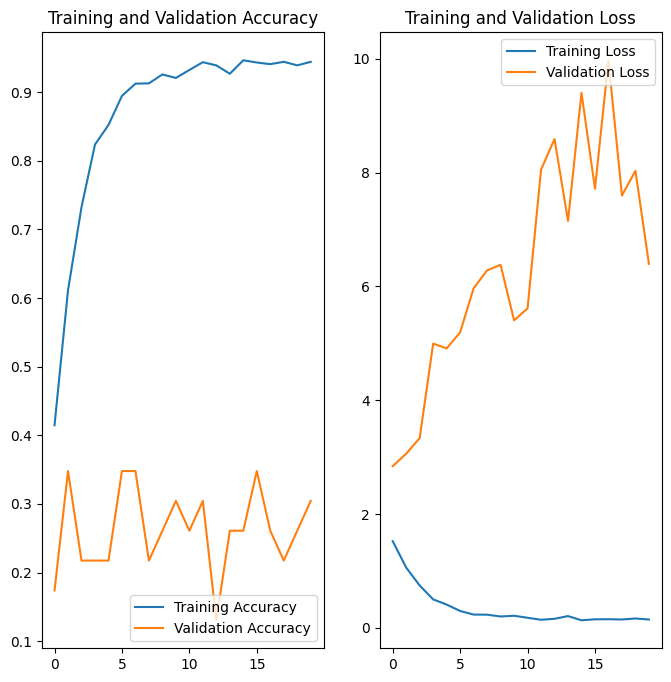

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations

There is clearly evidence of overfitting, with the difference between training accuracy and validation accuracy being greater than 0.5. In addition, as can be observed in the graphs above, as training proceeds, while training loss decreases, validation loss increases.

## Data Augmentation

Data augmentation 
The data augmentation performed will follow the recommendations found in the research paper Data Augmentation for Skin Lesion Analysis, Perez et al. 2018
https://arxiv.org/abs/1809.01442
The research paper investigated the impact of 13 data augmentation approaches on the performance of three CNNS (Inception-v4, ResNet, and DenseNet). The best augmentation scenario in Perez et al.'s paper was a a combination of geometric and colour transformations. To approximate this with the available keras layer types, we have opted for a mixture of RandomFlip, RandomRotation and RandomContrast and RandomBrightness, and the keras_cv augmentation layer of RandomColorDegeneration. We acknowledge the limitations of this approach, as our CNN does not have identical structure to the CNNs investigated in the paper, even though the application was melanoma classification.

### Creation of data augmentation layer architecture for reuse

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5),
    layers.RandomContrast(0.5),
    layers.RandomBrightness(0.3),
    keras_cv.layers.RandomColorDegeneration(0.5)
])

### Illustration of data augmentation showing 9 exemplars for a single image

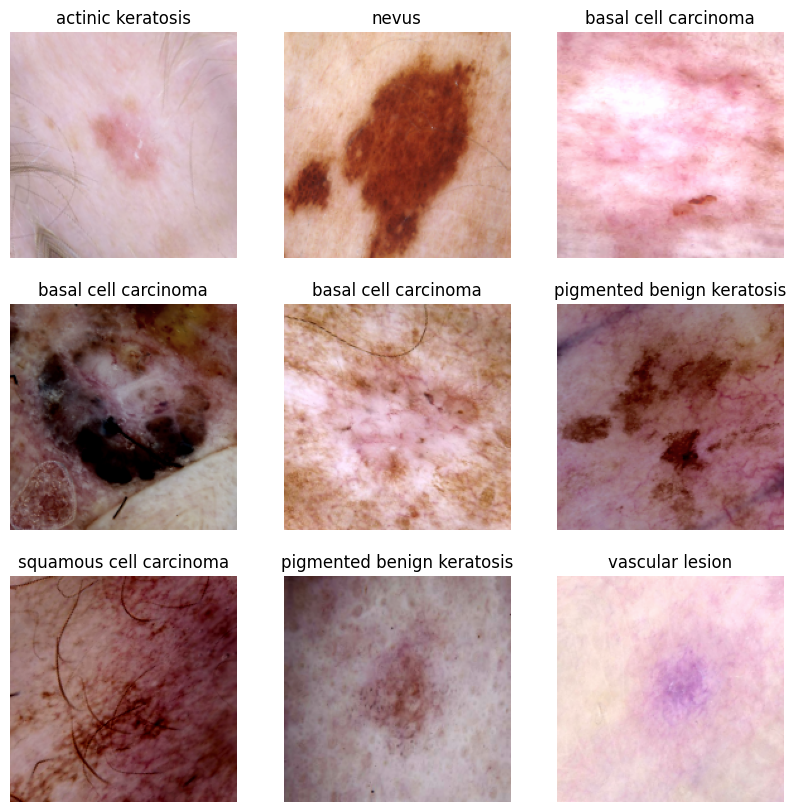

In [18]:
plt.figure(figsize=(10, 10))

for images, labels in cached_train_ds.take(1):  # Fetch a single batch of images and labels
    for i in range(9):  # Loop through the first 9 images in the batch
        img = images[i]  # Extract the i-th image from the batch
        augmented_image = data_augmentation(img)  # Apply data augmentation
        ax = plt.subplot(3, 3, i + 1)  # Create a 3x3 grid of subplots
        plt.imshow(augmented_image.numpy().astype("uint8"))  # Convert the augmented image for display
        plt.title(class_names[labels[i].numpy()])  # Fetch the corresponding class name
        plt.axis("off")  # Turn off axis details

## Model Creation with Augmentation and Dropout layers

Note that, as well as adding the data augmentation layers, dropout layers will also be added. As per Hinton (2012), these will be placed after each of the fully connected layers with p=0.5. As per Park and Kwak (2016), we will also add some dropout after the convolution layers, but with a much reduced p of 0.1.  


### Model Compilation
See above for justification of optimizer choice

In [19]:
model_aug_drop = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(180, 180, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),  # Dropout after pooling
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Higher dropout for dense layers
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Add softmax activation
])


In [20]:
model_aug_drop.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model Training

In [21]:
epochs = 20 # As specified in the project pipeline
history = model_aug_drop.fit(
  cached_train_ds,
  validation_data = cached_val_ds,
  epochs=epochs
)

Epoch 1/20


c:\Users\NC101478\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


394/394 ━━━━━━━━━━━━━━━━━━━━ 90s 223ms/step - accuracy: 0.1659 - loss: 2.1254 - val_accuracy: 0.3043 - val_loss: 2.0625
Epoch 2/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 88s 223ms/step - accuracy: 0.4269 - loss: 1.4819 - val_accuracy: 0.2174 - val_loss: 2.2308
Epoch 3/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 88s 224ms/step - accuracy: 0.4858 - loss: 1.3554 - val_accuracy: 0.2609 - val_loss: 2.7479
Epoch 4/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 94s 237ms/step - accuracy: 0.5421 - loss: 1.2036 - val_accuracy: 0.2609 - val_loss: 3.2347
Epoch 5/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 96s 243ms/step - accuracy: 0.5927 - loss: 1.0756 - val_accuracy: 0.2174 - val_loss: 3.0750
Epoch 6/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 92s 233ms/step - accuracy: 0.6416 - loss: 0.9499 - val_accuracy: 0.2174 - val_loss: 4.1143
Epoch 7/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 88s 225ms/step - accuracy: 0.6770 - loss: 0.8476 - val_accuracy: 0.2174 - val_loss: 4.5895
Epoch 8/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.7058 - loss: 0.7579 - val

### Visualization of training results

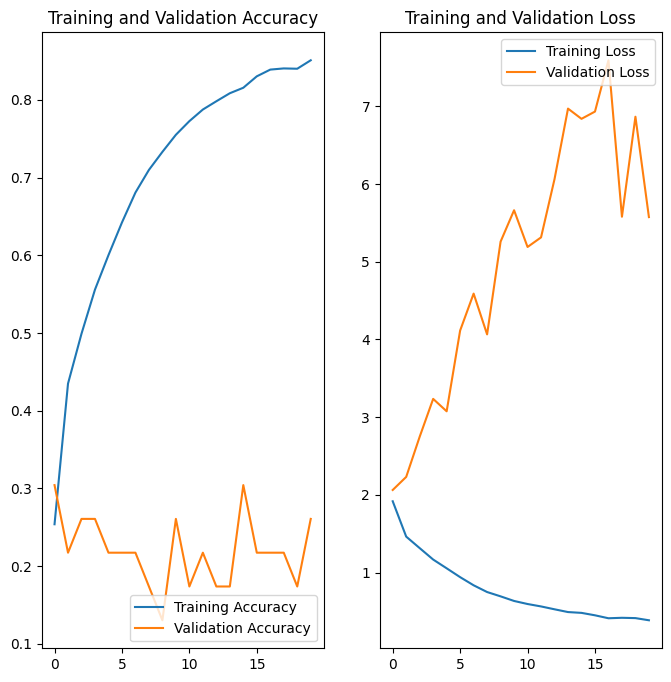

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Performance on the modified model

As can be seen, the model with augmentation layers and dropouts does not perform better on the training data, actually performing significantly worse. The model still performs poorly during inference using the validation set. There is some improvement, but the model is still overfitting.

## Display of the number of samples for each class/label

In [23]:
dataset_unbatched = tuple(train_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)

# adjustments
count = labels.value_counts().sort_index()
count.index = train_ds.class_names
print(count)

actinic keratosis             1297
basal cell carcinoma          1482
dermatofibroma                1267
melanoma                      1575
nevus                         1475
pigmented benign keratosis    1564
seborrheic keratosis          1263
squamous cell carcinoma       1346
vascular lesion               1323
Name: count, dtype: int64


### Notes on sample class distribution 
#### - Which class has the least number of samples?

Seborrheic keratosis has the least number of samples at 1263

#### - Which classes dominate the data in terms proportionate number of samples?

The classes with the most samples are:

melanoma 1575,
pigmented benign keratosis 1564,
basal cell carcinoma 1482,
nevus 1475. 
Clearly the classes  "melanoma" and "pigmented benign keratosis" dominate the data.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [24]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) + '/' + str(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D36B4DD990>: 100%|██████████| 500/500 [00:04<00:00, 109.02 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D36BF437D0>: 100%|██████████| 500/500 [00:05<00:00, 88.26 Samples/s]                   


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D36B4B8AD0>: 100%|██████████| 500/500 [00:05<00:00, 87.21 Samples/s]                   


Initialised with 438 image(s) found.
Output directory set to Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1D36C097E90>: 100%|██████████| 500/500 [00:29<00:00, 17.04 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x1D36EBCB490>: 100%|██████████| 500/500 [00:22<00:00, 21.94 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D36B7BD890>: 100%|██████████| 500/500 [00:05<00:00, 95.74 Samples/s]                   


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1D36BF58410>: 100%|██████████| 500/500 [00:10<00:00, 46.56 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D161DFFD10>: 100%|██████████| 500/500 [00:05<00:00, 94.79 Samples/s]                   


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D36B4CC950>: 100%|██████████| 500/500 [00:05<00:00, 91.58 Samples/s]                   


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [25]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

18000


#### Dataset Creation, Model Creation and Training

In [26]:
batch_size = 32
img_height = 180
img_width = 180

#### Training dataset creation

In [27]:
data_dir_train = pathlib.Path('./Train')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20239 files belonging to 9 classes.
Using 16192 files for training.


#### Validation dataset creation

In [28]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20239 files belonging to 9 classes.
Using 4047 files for validation.


#### Model Creation (including normalization)

In [29]:
num_classes = 9

model3 = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

#### Model Compilation

In [30]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Model Training
The original notebook and project pipeline contradict each other with various number of epochs given. This was reported to support with no feedback after more than a week, so 20 epochs was chosen as per the Evaluation Rubric (Note: the project pipeline asks for training for 30 epochs and some training has been tested using this value, but the code below specifies the Evaluation Rubric number.)

In [31]:
epochs = 30
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 120s 230ms/step - accuracy: 0.3417 - loss: 1.7008 - val_accuracy: 0.5849 - val_loss: 1.1281
Epoch 2/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 115s 227ms/step - accuracy: 0.6240 - loss: 1.0420 - val_accuracy: 0.7233 - val_loss: 0.7572
Epoch 3/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 117s 230ms/step - accuracy: 0.7611 - loss: 0.6758 - val_accuracy: 0.8199 - val_loss: 0.5398
Epoch 4/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 115s 228ms/step - accuracy: 0.8470 - loss: 0.4238 - val_accuracy: 0.8629 - val_loss: 0.4125
Epoch 5/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 117s 230ms/step - accuracy: 0.8857 - loss: 0.3259 - val_accuracy: 0.8811 - val_loss: 0.3505
Epoch 6/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 115s 227ms/step - accuracy: 0.9075 - loss: 0.2428 - val_accuracy: 0.9106 - val_loss: 0.2859
Epoch 7/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 113s 222ms/step - accuracy: 0.9215 - loss: 0.2130 - val_accuracy: 0.8582 - val_loss: 0.4364
Epoch 8/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 114s 224ms/step - accuracy: 0.9270 -

### Visualize the model results

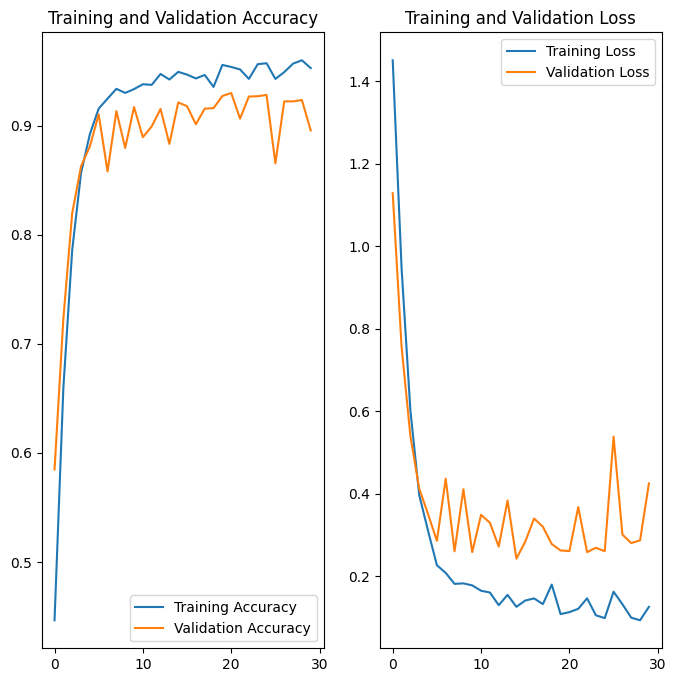

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Results Analysis

The results with dataset augmentation have shown significant improvement over previous models, with training accuracy of 0.9582 and validation accuracy at 0.9236 at 29 Epochs. 

The results demonstrate remarkable improvement following the application of dataset augmentation techniques. The model achieved an impressive training accuracy of 0.9582 and a commendable validation accuracy of 0.9236 at 29 epochs, signifying a well-trained and robust model.